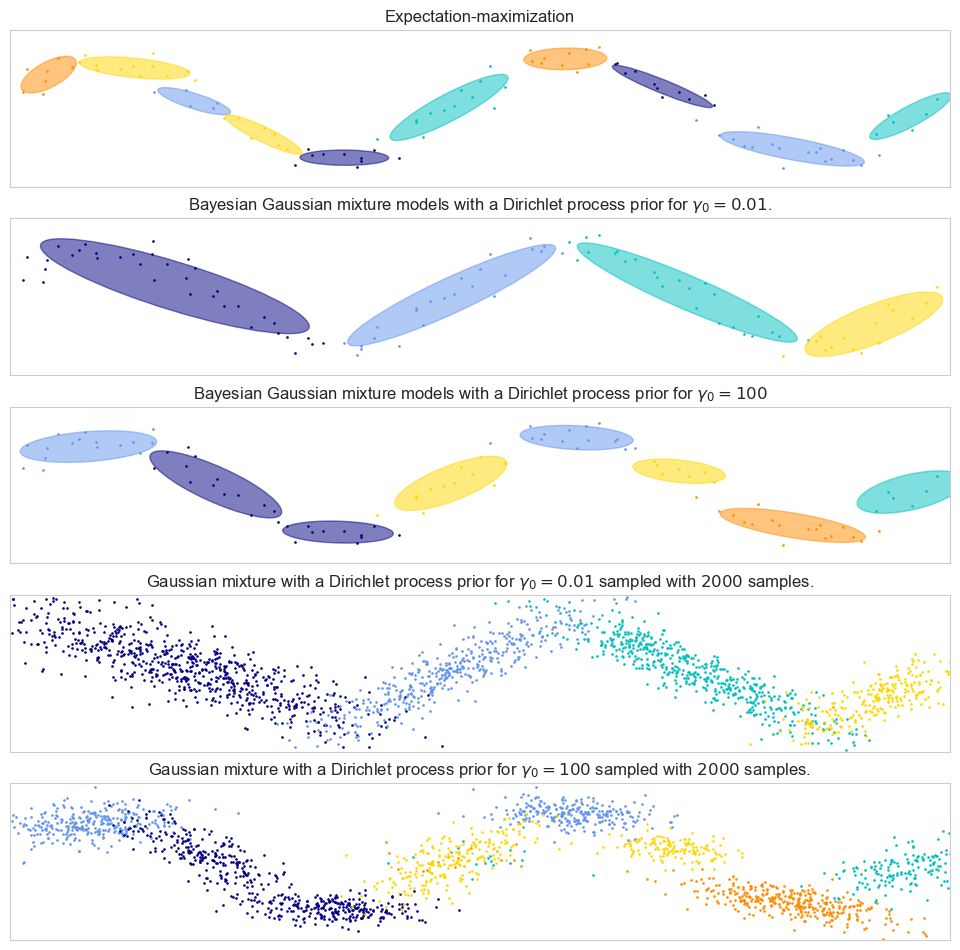

In [1]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4.0 * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.0
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3.0 * (np.sin(x) + np.random.normal(0, 0.2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(
    bottom=0.04, top=0.95, hspace=0.2, wspace=0.05, left=0.03, right=0.97
)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(
    n_components=10, covariance_type="full", max_iter=100
).fit(X)
plot_results(
    X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Expectation-maximization"
)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e-2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="random",
    max_iter=100,
    random_state=2,
).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=0.01$.",
)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    0,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=0.01$ sampled with $2000$ samples.",
)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="kmeans",
    max_iter=100,
    random_state=2,
).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    2,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=100$",
)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    1,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=100$ sampled with $2000$ samples.",
)

plt.show()